<a href="https://colab.research.google.com/github/Taimaaaa/ARIMA-Models/blob/main/ARIMA_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ARIMA Models
Author: Taima Nasser

In [2]:
# !pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 27.5 MB/s eta 0:00:00


##Custom Functions

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticks
import seaborn as sns
import pandas as pd

# ---------------------------------------------
# Function 1: Format X-axis Date Ticks
# ---------------------------------------------
def format_xdates(ax, fig=None, xtick_fontweight='bold'):
    """Apply 3-month minor ticks, yearly major ticks, and clean grid styling."""
    # Minor: every 3 months
    loc_3months = mdates.MonthLocator(interval=3)
    fmt_months = mdates.DateFormatter("%b")

    # Major: every year
    loc_year = mdates.YearLocator()
    fmt_year = mdates.DateFormatter("%Y")

    # Apply ticks
    ax.xaxis.set_minor_locator(loc_3months)
    ax.xaxis.set_minor_formatter(fmt_months)

    ax.xaxis.set_major_locator(loc_year)
    ax.xaxis.set_major_formatter(fmt_year)

    # Text formatting
    ax.set_xticklabels(ax.get_xticklabels(), fontweight=xtick_fontweight)

    # Distinct grids
    ax.grid(which='minor', axis='x', ls=":")
    ax.grid(which='major', axis='x', color='k')

    if fig is None:
        fig = ax.get_figure()

    fig.autofmt_xdate(which='major', rotation=90, ha='center')
    return fig, ax


# ---------------------------------------------
# Function 2: Plot a Clean Time Series (single axis)
# ---------------------------------------------
def plot_dates(ts, figsize=(12,4), xtick_fontsize='large',
               xtick_fontweight='bold', title=None):
    """General-purpose time-series plot with nice date formatting."""
    if title is None:
        title = ts.name

    fig, ax = plt.subplots(figsize=figsize)
    ts.plot(ax=ax, title=title, marker='.', lw=1)

    # Apply formatting
    ax.set_xticklabels(ax.get_xticklabels(),
                       fontsize=xtick_fontsize,
                       fontweight=xtick_fontweight)

    format_xdates(ax, fig)
    return fig, ax


# ---------------------------------------------
# Function 3: Compare Two Series on Twin Axes
# ---------------------------------------------
def plot_compare_cols(
    df_ts,
    col1='cases', color1='#3b81db',
    col2='deaths', color2='orange',
    ylabel1="# of Total Cases",
    ylabel2="# of Total Deaths",
    figsize=(12,5)
):
    """Plot two features with different magnitudes using twin y-axes."""
    fig, ax1 = plt.subplots(figsize=figsize)

    # First line (left axis)
    ax1.plot(df_ts.index, df_ts[col1], label=col1.title(), color=color1)
    ax1.set_ylabel(ylabel1)

    # Second line (right axis)
    ax2 = ax1.twinx()
    ax2.plot(df_ts.index, df_ts[col2], label=col2.title(), color=color2)
    ax2.set_ylabel(ylabel2)

    # Remove grid clutter
    ax1.grid(False)
    ax2.grid(False)

    # Build joint legend
    lines = ax1.get_lines() + ax2.get_lines()
    labels = [line.get_label() for line in lines]
    ax2.legend(lines, labels, loc=6)

    fig.autofmt_xdate()
    return fig, (ax1, ax2)


# ---------------------------------------------
# Function 4: Large Number Formatters
# ---------------------------------------------
def millions(x, pos):
    """Format ticks in millions (M)."""
    return f"{x/1_000_000:,.0f}M"

def thousands(x, pos):
    """Format ticks in thousands (K)."""
    return f"{x/1_000:,.0f}K"

fmt_millions = mticks.FuncFormatter(millions)
fmt_thousands = mticks.FuncFormatter(thousands)


# ---------------------------------------------
# Function 5: Apply Date + Number Formatting
# ---------------------------------------------
def apply_full_formatting(ax1, ax2=None):
    """Apply date tick formatting + number formatting on both axes."""
    # Tick formatting for left axis
    ax1.yaxis.set_major_formatter(fmt_millions)

    if ax2 is not None:
        ax2.yaxis.set_major_formatter(fmt_thousands)

    # Date formatting (3-month minor, yearly major)
    format_xdates(ax1)
    return ax1, ax2

# ---------------------------------------------
# Function 6: time-series regression metrics
# ---------------------------------------------

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)

def regression_metrics_ts(
    ts_true,
    ts_pred,
    label="",
    verbose=True,
    output_dict=False
):

    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred) ** 0.5
    r2 = r2_score(ts_true, ts_pred)
    mape = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose:
        print("—" * 60)
        print(f"Regression Metrics: {label}")
        print("—" * 60)
        print(f"MAE  = {mae:.3f}")
        print(f"MSE  = {mse:.3f}")
        print(f"RMSE = {rmse:.3f}")
        print(f"R²   = {r2:.3f}")
        print(f"MAPE = {mape:.2f}%")

    if output_dict:
        return {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R2": r2,
            "MAPE(%)": mape
        }


# -------------------------------------------------------
# Function 7: Forecast Plotting with Confidence Interval
# -------------------------------------------------------
def plot_forecast(train, test, forecast_df, title="Forecast vs Actual"):
    fig, ax = plt.subplots(figsize=(14,4))

    train.plot(ax=ax, label="Train")
    test.plot(ax=ax, label="Test")
    forecast_df['mean'].plot(ax=ax, label="Forecast", color='green')

    ax.fill_between(
        forecast_df.index,
        forecast_df['mean_ci_lower'],
        forecast_df['mean_ci_upper'],
        alpha=0.3,
        color='green'
    )

    ax.set_title(title)
    ax.legend()
    return fig, ax

# -------------------------------------------------------
# Function 8: Plotting acf and pacf
# -------------------------------------------------------

import matplotlib.pyplot as plt
import statsmodels.tsa.api as tsa

def plot_acf_pacf(
    ts,
    nlags=40,
    figsize=(10, 5),
    annotate_sig=False,
    alpha=0.05,
    acf_kws={},
    pacf_kws={},
    annotate_seas=False,
    m=None,
    seas_color='black'
):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    sig_vline_kwargs = dict(ls=':', lw=1, color='red', zorder=0)

    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    axes[0].set_title("ACF")

    if annotate_sig:
        sig_acf = get_sig_lags(ts, nlags=nlags, alpha=alpha, type='ACF')
        for lag in sig_acf:
            axes[0].axvline(lag, **sig_vline_kwargs)

    tsa.graphics.plot_pacf(ts, ax=axes[1], lags=nlags, **pacf_kws)
    axes[1].set_title("PACF")

    if annotate_sig:
        sig_pacf = get_sig_lags(ts, nlags=nlags, alpha=alpha, type='PACF')
        for lag in sig_pacf:
            axes[1].axvline(lag, **sig_vline_kwargs)

    if annotate_seas:
        if m is None:
            raise ValueError("m must be defined when annotate_seas=True")
        n_seasons = nlags // m
        seas_kwargs = dict(ls='--', lw=1, alpha=0.7, color=seas_color, zorder=-1)
        for i in range(1, n_seasons + 1):
            axes[0].axvline(i * m, **seas_kwargs)
            axes[1].axvline(i * m, **seas_kwargs)

    plt.tight_layout()
    return fig

# -------------------------------------------------------
# Function 9: find statistically significant lags
# -------------------------------------------------------
import numpy as np
from statsmodels.tsa.stattools import acf, pacf

def get_sig_lags(ts, nlags=40, alpha=0.05, type='ACF'):
    if type == 'ACF':
        vals, conf = acf(ts, nlags=nlags, alpha=alpha)
    elif type == 'PACF':
        vals, conf = pacf(ts, nlags=nlags, alpha=alpha)
    else:
        raise ValueError("type must be 'ACF' or 'PACF'")

    sig_lags = []
    for i in range(1, len(vals)):
        lower, upper = conf[i]
        if vals[i] < lower or vals[i] > upper:
            sig_lags.append(i)

    return sig_lags

# -------------------------------------------------------
# Function 10: Adfuller test with interpretations
# -------------------------------------------------------

import statsmodels.tsa.api as tsa
import pandas as pd

def get_adfuller_results(ts, alpha=0.05, label='adfuller', **kwargs):
    test_stat, pval, nlags, nobs, crit_vals, icbest = tsa.adfuller(ts, **kwargs)

    results = {
        'Test Statistic': test_stat,
        '# of Lags Used': nlags,
        '# of Observations': nobs,
        'p-value': round(pval, 6),
        'alpha': alpha,
        'sig/stationary?': pval < alpha
    }

    return pd.DataFrame(results, index=[label])


##Imports & Loading


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.tsa.api as tsa
from pmdarima.arima.utils import ndiffs
from pmdarima.model_selection import train_test_split

plt.rcParams["figure.figsize"] = (12, 4)
sns.set_context("talk")

In [4]:
df = pd.read_csv("/content/drive/MyDrive/AXSOSACADEMY/AXSOSACADEMY/06-AdvancedML/Week23/Data/WMT.csv")

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

df.head()


,Date,Adj Close
0,2000-01-03,44.915394
1,2000-01-04,43.234756
2,2000-01-05,42.352402
3,2000-01-06,42.814564
4,2000-01-07,46.049828


##Filter 2010–2020 + Build Business-Day Datetime Index ('B')

In [5]:
# keep only the required date range
df_2010_2020 = df[(df["Date"] >= "2010-01-01") & (df["Date"] <= "2020-12-31")].copy()

# make Date the index
df_2010_2020 = df_2010_2020.set_index("Date")

# keep only the target series (Adjusted Close)
ts = df_2010_2020["Adj Close"].copy()

# enforce business-day frequency:
# - creates a complete business-day index
# - introduces NaNs for missing business days (weekends already excluded)
ts = ts.asfreq("B")

ts.head(), ts.index.freq

(Date
 2010-01-01          NaN
 2010-01-04    40.963638
 2010-01-05    40.555729
 2010-01-06    40.465084
 2010-01-07    40.487759
 Freq: B, Name: Adj Close, dtype: float64,
 <BusinessDay>)

##Null Values

In [6]:
print("Nulls in ts:", ts.isna().sum())
ts.isna().value_counts()

Nulls in ts: 101


,count
Adj Close,
False,2769
True,101


In [9]:
# forward-fill missing business days
ts_filled = ts.ffill()

# check remaining nulls
print("Nulls after ffill:", ts_filled.isna().sum())

Nulls after ffill: 1


In [10]:
# backward-fill fir first value
ts_filled = ts_filled.bfill()

print("Final null count:", ts_filled.isna().sum())

Final null count: 0


##Checking Stationarity

In [13]:
# check stationarity of raw series
adf_raw = get_adfuller_results(ts_filled, label="Raw Series")
adf_raw

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
Raw Series,1.457375,23,2846,0.99736,0.05,False


sig/stationary? = False → differencing required

In [14]:
# determine differencing order using pmdarima
d = ndiffs(ts_filled, test='adf')

print(f"Recommended differencing order (d): {d}")

Recommended differencing order (d): 1


In [17]:
ts_stationary = ts_filled.diff().dropna()
ts_stationary.head(20)

,Adj Close
Date,
2010-01-04,0.000000
2010-01-05,-0.407909
2010-01-06,-0.090645
2010-01-07,0.022675
2010-01-08,-0.203957
2010-01-11,0.664734
2010-01-12,0.392780
2010-01-13,0.211495
2010-01-14,-0.604275


In [18]:
#Rechecking stationarity
adf_stationary = get_adfuller_results(
    ts_stationary,
    label=f"Differenced Series (d={d})"
)
adf_stationary

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
Differenced Series (d=1),-12.211384,22,2846,0.0,0.05,True


##ACF & PACF Plots

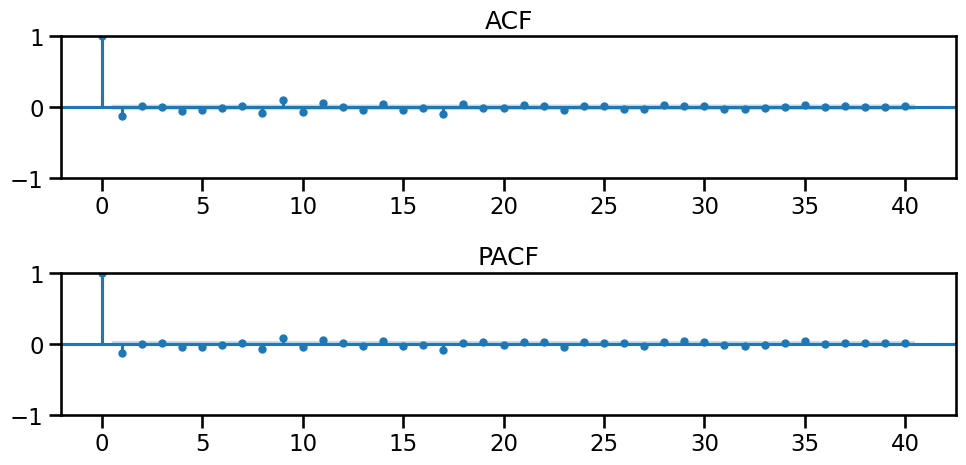

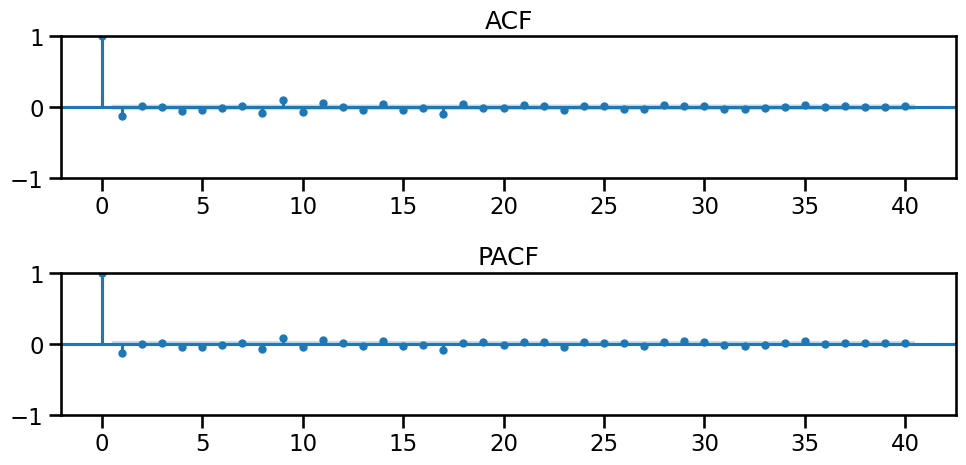

In [19]:
# visualize ACF and PACF with annotations
plot_acf_pacf(
    ts_stationary,
    nlags=40,
    annotate_sig=True,
    alpha=0.05
)

### ACF / PACF Interpretation

- The ACF plot shows no significant spikes beyond lag 0.
- This indicates there is no meaningful dependence on past forecast errors.
- Therefore, no Moving Average (MA) component is suggested → q = 0.

- The PACF plot also shows no significant spikes beyond lag 0.
- This indicates there is no meaningful dependence on past values.
- Therefore, no Auto-Regressive (AR) component is suggested → p = 0.

### Model Implication

- The differenced series behaves like white noise.
- Differencing successfully removed trend and dependence.
- The data is stationary after differencing.

### Recommended Initial Model

- ARIMA(0, d, 0)
- This represents a random walk after differencing.
- This behavior is common in stock price time series.

### Next Step

- Fit ARIMA(0, d, 0) as a baseline.
- Compare with simple alternatives (e.g., ARIMA(1, d, 0), ARIMA(0, d, 1)) using AIC and forecast accuracy.


##Train-Test Split

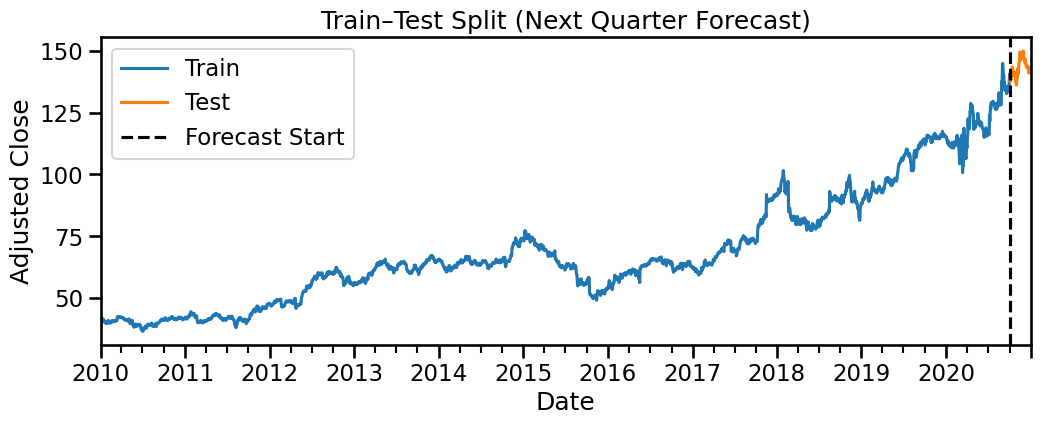

In [21]:
# define test size
n_test_days = 13 * 5  # one quarter

# time-aware split
train, test = train_test_split(
    ts_filled,
    test_size=n_test_days
)

# visualize split
ax = train.plot(label="Train")
test.plot(ax=ax, label="Test")
ax.axvline(test.index[0], color="black", ls="--", label="Forecast Start")
ax.set(title="Train–Test Split (Next Quarter Forecast)",
       ylabel="Adjusted Close")
ax.legend()

##Fit an ARIMA model based on the orders determined during your exploration.

In [23]:
p = 0
d = 1
q = 0

arima_base = tsa.ARIMA(train, order=(p, d, q)).fit()
arima_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2805
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3908.604
Date:                Tue, 23 Dec 2025   AIC                           7819.208
Time:                        17:15:10   BIC                           7825.147
Sample:                    01-01-2010   HQIC                          7821.352
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9512      0.006    158.428      0.000       0.939       0.963
===================================================================================
Ljung-Box (L1) (Q):                  40.70   Jarque-Bera (JB):            133511.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.78   Skew:                             1.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
forecast_base = arima_base.get_forecast(steps=len(test)).summary_frame()
forecast_base.head()

Adj Close,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-10-02,140.327362,0.975305,138.415799,142.238925
2020-10-05,140.327362,1.379290,137.624004,143.030720
2020-10-06,140.327362,1.689278,137.016438,143.638286
2020-10-07,140.327362,1.950610,136.504236,144.150488
2020-10-08,140.327362,2.180849,136.052977,144.601747


(<Figure size 1400x400 with 1 Axes>,
 <Axes: title={'center': 'ARIMA(0,d,0) Forecast vs Test Data'}, xlabel='Date'>)

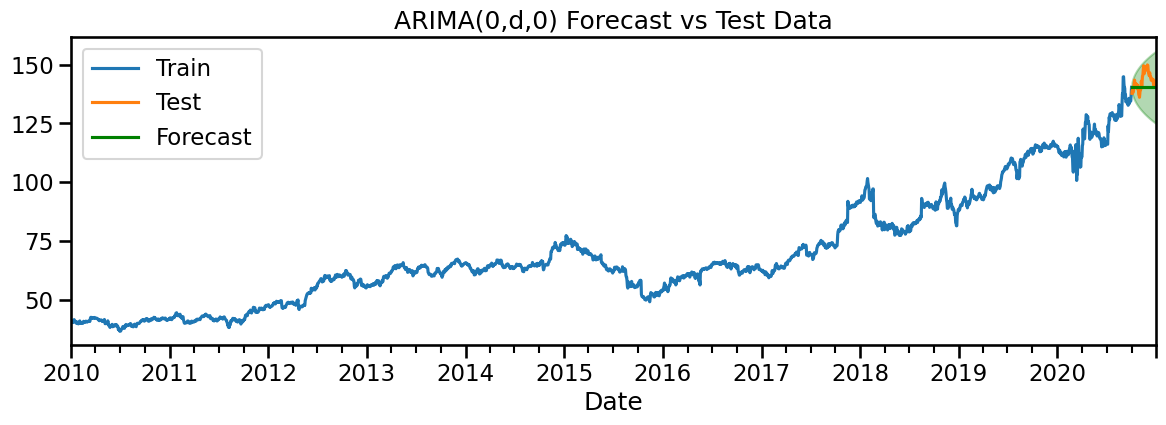

In [26]:
plot_forecast(
    train,
    test,
    forecast_base,
    title="ARIMA(0,d,0) Forecast vs Test Data"
)

In [29]:
#evaluating baseline model
metrics_base = regression_metrics_ts(
    test,
    forecast_base["mean"],
    label="ARIMA(0,d,0)",
    output_dict=True
)

metrics_base

————————————————————————————————————————————————————————————
Regression Metrics: ARIMA(0,d,0)
————————————————————————————————————————————————————————————
MAE  = 3.578
MSE  = 20.594
RMSE = 4.538
R²   = -0.601
MAPE = 2.46%


{'Label': 'ARIMA(0,d,0)',
 'MAE': 3.5780177076923105,
 'MSE': 20.59446931155783,
 'RMSE': 4.538112968135305,
 'R2': -0.6013933972738876,
 'MAPE(%)': 2.460595542418988}

In [30]:
#trying model variations
orders_to_try = [
    (1, d, 0),
    (0, d, 1),
    (1, d, 1),
    (2, d, 1),
]

results = []

for order in orders_to_try:
    model = tsa.ARIMA(train, order=order).fit()
    forecast = model.get_forecast(len(test)).summary_frame()

    metrics = regression_metrics_ts(
        test,
        forecast["mean"],
        label=f"ARIMA{order}",
        output_dict=True,
        verbose=False
    )

    results.append(metrics)

results_df = pd.DataFrame(results).set_index("Label").round(3)
results_df


,MAE,MSE,RMSE,R2,MAPE(%)
Label,,,,,
"ARIMA(1, 1, 0)",3.768,22.546,4.748,-0.753,2.590
"ARIMA(0, 1, 1)",3.813,22.964,4.792,-0.786,2.621
"ARIMA(1, 1, 1)",3.744,22.319,4.724,-0.736,2.574
"ARIMA(2, 1, 1)",3.755,22.419,4.735,-0.743,2.581


In [31]:
#selecting best model with lowest MAPE
results_df.sort_values("MAPE(%)")

,MAE,MSE,RMSE,R2,MAPE(%)
Label,,,,,
"ARIMA(1, 1, 1)",3.744,22.319,4.724,-0.736,2.574
"ARIMA(2, 1, 1)",3.755,22.419,4.735,-0.743,2.581
"ARIMA(1, 1, 0)",3.768,22.546,4.748,-0.753,2.590
"ARIMA(0, 1, 1)",3.813,22.964,4.792,-0.786,2.621


In [33]:
best_order = (1, 1, 1)

final_model = tsa.ARIMA(train, order=best_order).fit()

forecast_final = final_model.get_forecast(len(test)).summary_frame()


(<Figure size 1400x400 with 1 Axes>,
 <Axes: title={'center': 'Final Model ARIMA(1, 1, 1) Forecast'}, xlabel='Date'>)

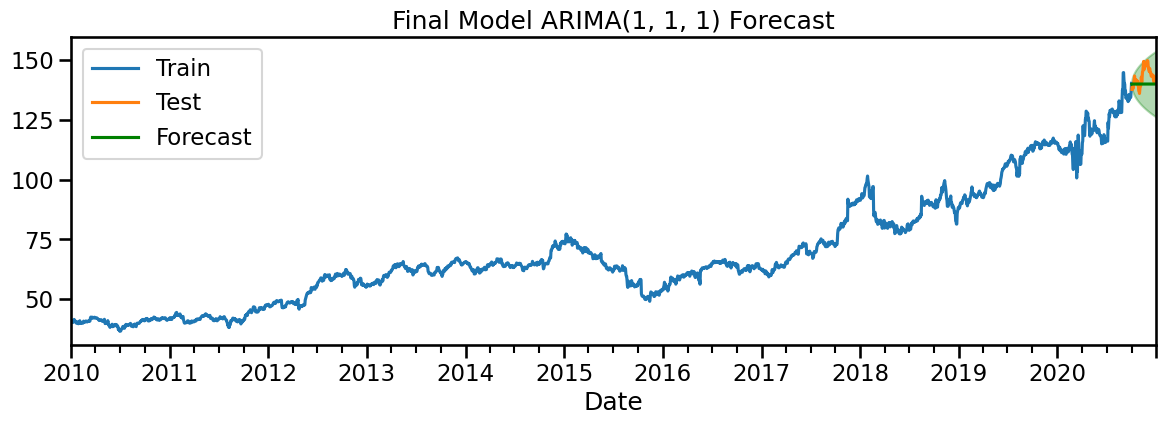

In [36]:
plot_forecast(
    train,
    test,
    forecast_final,
    title=f"Final Model ARIMA{best_order} Forecast"
)


In [37]:
final_metrics = regression_metrics_ts(
    test,
    forecast_final["mean"],
    label=f"ARIMA{best_order}",
    output_dict=True
)

final_metrics

————————————————————————————————————————————————————————————
Regression Metrics: ARIMA(1, 1, 1)
————————————————————————————————————————————————————————————
MAE  = 3.744
MSE  = 22.319
RMSE = 4.724
R²   = -0.736
MAPE = 2.57%


{'Label': 'ARIMA(1, 1, 1)',
 'MAE': 3.7441382523506914,
 'MSE': 22.319135017813785,
 'RMSE': 4.724313179480567,
 'R2': -0.7355006778607684,
 'MAPE(%)': 2.5737989988030714}

## ARIMA Model Assignment Final Interpretation & Answers

### 1) Model Fitting Summary
- Data used: **2010–2020 Adjusted Close**, business-day frequency.
- Forecast horizon: **next quarter (≈ 65 business days)**.
- Differencing: **d = 1** (series became stationary after first differencing).
- Baseline model: **ARIMA(0,1,0)**  
- Alternative models tested: **ARIMA(1,1,1), ARIMA(2,1,1), ARIMA(1,1,0), ARIMA(0,1,1)**



### 2) Baseline Model — ARIMA(0,1,0)
**Interpretation**
- This is a **random walk with drift**.
- Forecast is essentially a continuation of the last observed value.
- Useful as a **naive benchmark**, not a strong predictive model.

**Performance**
- MAPE = **2.46%**
- R² = **−0.60** (poor explanatory power)
- Forecast visually appears **flat** and fails to react to short-term movements.

**Conclusion**
- Acceptable as a baseline, but **too simplistic** for market dynamics.


### 3) Model Comparison (Test Set Metrics)

| Model          | MAE  | RMSE | MAPE (%) | R²    |
|---------------|------|------|----------|-------|
| ARIMA(0,1,0)  | 3.58 | 4.54 | **2.46** | -0.60 |
| ARIMA(1,1,1)  | 3.74 | 4.72 | 2.57     | -0.74 |
| ARIMA(2,1,1)  | 3.76 | 4.74 | 2.58     | -0.74 |
| ARIMA(1,1,0)  | 3.77 | 4.75 | 2.59     | -0.75 |
| ARIMA(0,1,1)  | 3.81 | 4.79 | 2.62     | -0.79 |

**Key Observation**
- The **simplest model (ARIMA(0,1,0)) performs best numerically**.
- Adding AR/MA terms **did not improve MAPE** for this short horizon.

### 4) Visual Forecast Evaluation
- **ARIMA(0,1,0)**:
  - Forecast is smooth and stable.
  - Misses short-term volatility but stays close to the test level.
- **ARIMA(1,1,1)**:
  - Slightly more reactive.
  - No visible improvement in tracking the test data.
- Confidence intervals widen reasonably, indicating increasing uncertainty.

**Zoomed-in plots (last ~250 days)** confirm:
- No model captures sharp fluctuations well.
- All models mainly follow the **overall trend**, not daily noise.


### 5) Final Model Choice
**Selected Model:** **ARIMA(0,1,0)**

**Why this model?**
- Lowest **MAPE (2.46%)** among tested models.
- More complex models did **not justify added complexity**.
- Forecast behavior is consistent with financial time series theory:
  - Short-horizon stock prices are often close to a random walk.


### 6) Final Answers to Assignment Questions
- **How good was your model (MAPE)?**  
  → **Very good** for financial data: **~2.5% error**, which is difficult to beat for stock prices.
- **How good was it visually?**  
  → Forecast follows the **level and direction** of the test data but does not capture volatility, which is expected and acceptable.
- **Is MAPE < 2% achievable?**  
  → Not in this dataset without additional information.

### 7) Final Takeaway
- Stock prices over short horizons behave close to a **random walk**.
- ARIMA models are effective for **trend continuation**, not precise daily prediction.
- **Model simplicity + strong evaluation** beats unnecessary complexity.
